<a href="https://colab.research.google.com/github/PavelNovikov888/mathematics/blob/master/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%B2%D1%80%D1%83%D1%87%D0%BD%D1%83%D1%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1cnJZhJrUBdt_751YFgrDt82wPzk5IUze"})
# https://drive.google.com/file/d/1cnJZhJrUBdt_751YFgrDt82wPzk5IUze/view?usp=sharing
download.GetContentFile("unconv.csv")

# Описание задачи

Компания добывает газ.  
Есть данные о добыче газа на скважинах.   
Наша задача — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты работы модели.  
  


# Данные

Признаки:

- Well — идентификатор скважины;   
- Por — пористость скважины (%);   
- Perm — проницаемость скважины;   
- AI — акустический импеданс (\(кг/м^2*10^6\));  
- Brittle — коэффициент хрупкости скважины (%);   
- TOC — общий органический углерод (%);  
- VR — коэффициент отражения витринита (%);   
- Prod — добыча газа в сутки (млн. кубических футов).  


In [ ]:
data = pd.read_csv('unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [ ]:
data.shape

(200, 8)

## Корреляционная матрица

<Axes: >

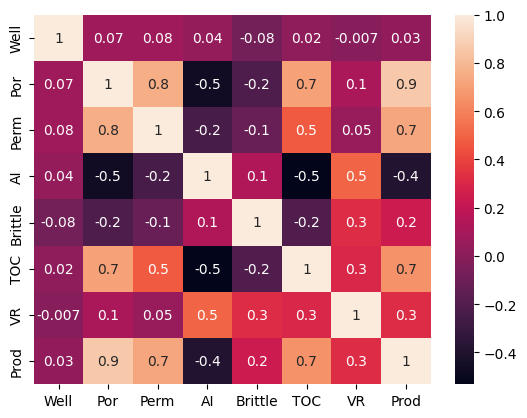

In [ ]:
# найдем наиболее скоррелированнные с целевым признаком признаки
h = data.corr()
sns.heatmap(h, annot = True, fmt='.1g')

Сильно скоррелированы с Prod признаки Por, Perm, TOC

In [ ]:
#Вычислим ранг корреляционной матрицы
print(np.linalg.matrix_rank(h))

8


Показатель ранга максимален, чистой коллинеарности нет.

In [ ]:
#Вычислите определитель матрицы корреляций
print(round(np.linalg.det(h),4))

0.0007


Однако, корреляционная матрица плохо обусловлена, т.к. определитель близок к 0.

# Простая линейная регрессия

In [20]:
# Матрица наблюдений
X = data.drop('Prod', axis=1)
# целевой признак
y = data['Prod'].values
# список индексов
index = ['intercept']+list(X.columns)
# количество строк в матрице наблюдений
n = X.shape[0]
# присоединяем единичный вектор-константу к матрице наблюдений
X = np.column_stack((np.ones(n), X))
# строим модель по методу МНК
w_hat = np.linalg.inv(X.T@X)@X.T@y
# выводим на экран полученные оценки коэффицентов модели
print(pd.Series(np.round(w_hat, 0), index=index))

intercept   -1232.0
Well            0.0
Por           230.0
Perm          116.0
AI           -365.0
Brittle        25.0
TOC           -78.0
VR            785.0
dtype: float64


Признак Well не информативен и не влияет на прогноз.

## Прогнозы и оценка ошибок
Построим прогноз выработки газа для скважины с параметрами, указанными ниже.

In [21]:
# новые параметры выработки
x_new = np.array([1, 106, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42])
# фактические показатели добычи
y_new = 4748.315024
# прогноз
y_new_pred = x_new @ w_hat
# абсолютная ошибка прогноза
print(f'Абсолютная ошибка прогноза для предложенной скважины (в миллионах кубических футов в день): {np.round(np.abs(y_new_pred - y_new), 0)}')

Абсолютная ошибка прогноза для предложенной скважины (в миллионах кубических футов в день): 25.0


Построим прогноз выработки газа для всех скважин из обучающего набора данных.
  
Чему равно значение метрики MAPE?

In [28]:
from sklearn.metrics import mean_absolute_percentage_error
# делаем прогноз для всех скважин
y_pred = X @ w_hat
# отобразим ошибку
print('Средняя абсолютная процентная ошибка MAPE: {:.1f} % '.format(mean_absolute_percentage_error(y, y_pred)*100))

Средняя абсолютная процентная ошибка MAPE: 3.6 % 


## Анализ построенной модели

Сравним полученные коэффициенты и их знаки со значениями выборочных корреляций между целевым признаком и факторами, найденными ранее.


Найдем в модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции.  
Например, корреляция говорит, что зависимость между фактором и целью прямая, а модель говорит обратное.

Такой коэффициент Wtoc ~ 78 .

Результат объясняется наличием сильной мультиколлинеарности в данных, которая «портит» коэффициенты.   
   
Согласно построенной модели, зависимость между процентом органического углерода и производительностью скважины обратная.   
Однако, согласно положительному коэффициенту корреляции между этим факторым и целевым признаком, равным 0.65 (а также согласно реальным фактам из сферы добычи газа), зависимость должна быть прямой.  
Чтобы убедиться в этом, построим диаграмму рассеяния, отражающую зависимость между TOC и Pro.


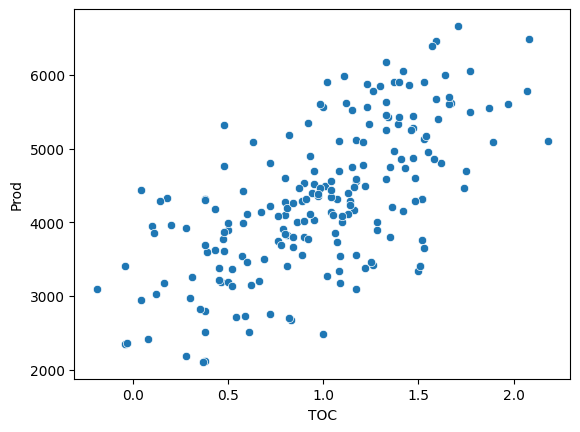

In [ ]:
sns.scatterplot(x='TOC', y='Prod', data=data);

Из графика видно, что зависимость прямая и линейная.

# Модель без мультиколлинеарности

Исключим из данных сильно коррелированные (>70) между собой факторы.   
Выбирая, какой из коррелированных факторов оставить, руководствуемся коэффициентом корреляции с целевой переменной: оставляем тот фактор, который больше всего коррелирует с объёмом добычи газа.

Также исключаем из данных факторы, для которых корреляция с целевой переменной меньше 0.05.

К таким факторам относятся 'Perm', 'TOC', 'Well'

In [29]:
from sklearn.metrics import mean_absolute_percentage_error
# матрица наблюдений
X = data.drop(['Prod', 'Perm', 'TOC', 'Well'], axis=1)
# целевой признак
y = data['Prod'].values
# индекс для таблицы получившихся коэффицентов
index = ['intercept']+list(X.columns)
# количество наблюдений
n = X.shape[0]
# добавим единичный вектор-столбец
X = np.column_stack((np.ones(n), X))
# построим методом МНК
w_hat = np.linalg.inv(X.T@X)@X.T@y
# сделаем прогноз
y_pred = X @ w_hat
# напечатаем коэффиценты модели
print(pd.Series(np.round(w_hat, 0), index=index))
# выведем ошибку
print('Средняя абсолютная процентная ошибка MAPE: {:.1f} % '.format(mean_absolute_percentage_error(y, y_pred)*100))

intercept   -1835.0
Por           293.0
AI           -200.0
Brittle        28.0
VR            517.0
dtype: float64
Средняя абсолютная процентная ошибка MAPE: 4.0 % 


Вывод: Нам удалось побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции, знаки корреляций совпадают со знаками коэффициентов регрессии.  
Это произошло благодаря избавлению от мультиколлинеарности.

Ранее, в юните 5, мы смогли построить модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. Далее мы будем использовать именно их (см. задание 5.5).

Мы хотим попробовать улучшить наш результат — метрику MAPE. Для этого воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку, поэтому для контроля качества модели мы будем использовать кросс-валидацию.

Сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов PolynomialFeatures из библиотеки sklearn. Параметр include_bias установите в значение False.

1. Сколько факторов у вас получилось после генерации полиномиальных признаков?

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
X = data.drop(['Prod', 'Perm', 'TOC', 'Well'], axis=1)
y = data['Prod'].values
#добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias= False)
X_poly = poly.fit_transform(X)
print(X_poly.shape)

(200, 34)


In [ ]:
#создаем модель линейной регрессии
from sklearn.linear_model import LinearRegression

# создаём модель линейной регрессии
lr = LinearRegression()
lr.fit(X_poly,y)
# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(lr, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.1f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.1f} %'.format(-cv_results['test_score'].mean() * 100))


MAPE на тренировочных фолдах: 1.8 %
MAPE на валидационных фолдах: 2.7 %


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

X = data.drop(['Prod', 'Perm', 'TOC', 'Well'], axis=1)
y = data['Prod'].values
scaler=StandardScaler()
X = scaler.fit_transform(X)
poly = PolynomialFeatures(degree=3, include_bias= False)
X_poly = poly.fit_transform(X)
lasso = linear_model.Lasso(alpha=5)
lasso.fit(X_poly, y)

# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(lasso, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.1f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.1f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.8 %
MAPE на валидационных фолдах: 2.3 %


In [ ]:
X = data.drop(['Prod', 'Perm', 'TOC', 'Well'], axis=1)
y = data['Prod'].values
scaler=StandardScaler()
X_scaled = scaler.fit_transform(X)
poly = PolynomialFeatures(degree=3, include_bias= False)
X_poly = poly.fit_transform(X_scaled)
ridge = linear_model.Ridge(alpha=1)
ridge.fit(X_poly, y)

# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(ridge, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.1f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.1f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.8 %
MAPE на валидационных фолдах: 2.7 %
